## Getting started with Axtreme

In this notebook we walk through the core ideas behind **Axtreme** on a simple toy problem:

- Step 1: Define the problem in terms of:
   - a **simulator** (the physics / system model), and  
   - an **environment distribution** (how the inputs vary in the real world).
- Step:2 Use **brute force** to compute a reference answer for our **Quantity of Interest** (QoI).
- Step 3: Build a **surrogate model** of the simulator using **Ax + BoTorch**.
- Step 4: Use that surrogate to **estimate the QoI much more cheaply**.
- Step 5: Use **Design of Experiments (DoE)** to choose simulator points intelligently and reduce QoI uncertainty faster.

The imports below set up:

- **Numerics & plotting**: `numpy`, `pandas`, `torch`, `matplotlib`
- **Ax / BoTorch**: experiment definition and Gaussian-process modelling
- **Axtreme**: helper functions for QoI estimation and DoE tailored to extreme responses
- **Toy example code**: a small Gumbel-based simulator and environment data used only for this tutorial


In [ ]:
import sys
from collections.abc import Callable
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import scipy
import torch
from ax import Experiment, SearchSpace
from ax.core import GeneratorRun, ObservationFeatures, ParameterType, RangeParameter
from ax.modelbridge.registry import Models
from scipy.stats import gumbel_r
from torch.distributions import Normal
from torch.utils.data import DataLoader

from axtreme import sampling
from axtreme.acquisition import QoILookAhead
from axtreme.data import FixedRandomSampler, MinimalDataset
from axtreme.experiment import add_sobol_points_to_experiment, make_experiment
from axtreme.metrics import QoIMetric
from axtreme.plotting.doe import plot_qoi_estimates_from_experiment
from axtreme.plotting.histogram3d import histogram_surface3d
from axtreme.qoi import MarginalCDFExtrapolation
from axtreme.sampling.ut_sampler import UTSampler
from axtreme.utils import population_estimators, transforms

# Configure torch
torch.set_default_dtype(torch.float64)

# Load the toy problem
root_dir = Path("../")
sys.path.append(str(root_dir))
from examples.basic_example_usecase.problem.brute_force import collect_or_calculate_results
from examples.basic_example_usecase.problem.env_data import collect_data
from examples.basic_example_usecase.problem.simulator import DummySimulatorSeeded

print("✓ Setup complete")

✓ Setup complete


### Axtreme Workflow Overview

The following diagram illustrates the general Axtreme process for extreme response estimation:

**Key Steps:**

1. **Problem Definition**: Specify the simulator and environment distribution
2. **Surrogate Modeling**: Build a GP-based approximation using Ax/BoTorch
3. **QoI Estimation**: Efficiently estimate the Quantity of Interest using the surrogate
4. **Uncertainty Check**: Assess if the QoI uncertainty is acceptable
5. **Design of Experiments**: Iteratively refine the surrogate by intelligently selecting new evaluation points

```mermaid
flowchart TD
    A[1. Define Problem] --> A1[Simulator Function]
    A[1. Define Problem] --> A2[Environment Distribution]
    
    A1 --> B[2. Build Surrogate]
    A2 --> B
    B --> B1[Define Search Space]
    B1 --> B2[Generate Training Data]
    B2 --> B3[Evaluate Simulator]
    B3 --> B4[Fit GP Model]
    
    B4 --> C[3. Estimate QoI]
    C --> C1[Setup Env Samples]
    C1 --> C2[Choose QoI Estimator]
    C2 --> C3[Compute QoI]
    
    C3 --> D{4. Acceptable?}
    D -->|No| E[5. Design of Experiments]
    D -->|Yes| F[Final QoI Estimate]
    
    E --> E1[Select Acquisition]
    E1 -->|Space-filling| E2[Sobol/Random]
    E1 -->|QoI-aware| E3[QoILookAhead]
    
    E2 --> E4[Next Point]
    E3 --> E4
    E4 --> E5[Evaluate]
    E5 --> E6[Update Surrogate]
    E6 --> C3
    
    style A fill:#e1f5ff
    style B fill:#e8f5e9
    style C fill:#f3e5f5
    style D fill:#fff4e1
    style E fill:#ffe0e0
    style F fill:#c8e6c9
```

### Tutorial Note:
This tutorial also computes a **brute-force reference** QoI using extensive simulation runs. This is done purely for validation purposes to demonstrate that Axtreme converges to the correct answer. In real applications, such brute-force computation is typically too expensive or infeasible.


## Step 1: Problem Inputs

The `axtreme` package needs two core ingredients:

1. A **simulator**  
2. A set of **environment samples**

These two objects completely define the *probabilistic problem* we want to solve.

### 1.1 Simulator

The simulator is a function

$$
x \mapsto y
$$

where:

- $x$ is a vector of input / environment variables (here a 2D point: `x = [x1, x2]` in $[0, 1]^2$).
- $y$ is a **random** output because the simulator includes noise.

In this toy problem the noise model is a **Gumbel distribution**:

- The simulator is parameterised by:
  - a **location** function `loc(x)` and
  - a **scale** function `scale(x)`
- For each input $x$ the output is:

  $$
  y \sim \text{Gumbel}(\text{loc}(x), \text{scale}(x))
  $$

In a real application, we **don't know** the true `loc(x)` and `scale(x)`; we only see noisy simulator outputs.  
Here we cheat a little: we have access to the "true" functions so we can visualise what is going on and check that our methods behave sensibly.

**Visualizing the stochastic nature of the simulator:**

Below we run the simulator 500 times at the same input point $x = [0.5, 0.5]$. The histogram shows the characteristic right-skewed shape of a Gumbel distribution — this is the noise model built into our toy simulator.

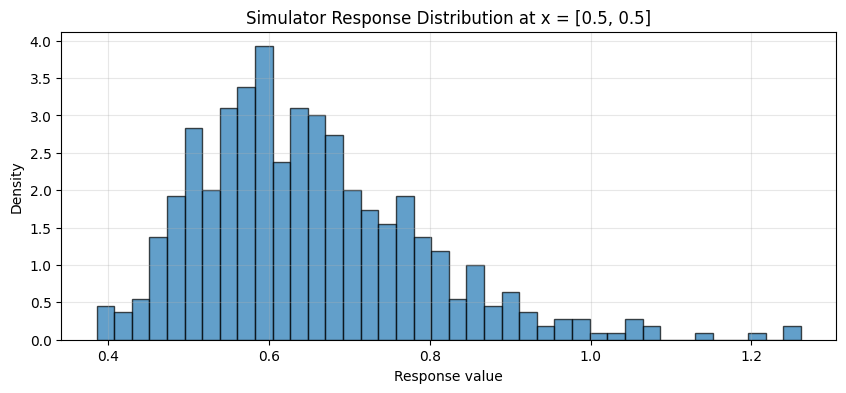

The histogram shows the Gumbel-shaped distribution of simulator responses at a fixed input point.


In [ ]:
# Use the seeded simulator for reproducible results
sim = DummySimulatorSeeded()

# Run the simulator multiple times at the same point to visualize the response distribution
test_point = np.array([[0.5, 0.5]])
n_samples = 500
response = sim(test_point, n_simulations_per_point=n_samples)

# Visualize the distribution of simulator responses
plt.figure(figsize=(10, 4))
plt.hist(response.flatten(), bins=40, density=True, alpha=0.7, edgecolor="black")
plt.xlabel("Response value")
plt.ylabel("Density")
plt.title("Simulator Response Distribution at x = [0.5, 0.5]")
plt.grid(alpha=0.3)
plt.show()

print("The histogram shows the Gumbel-shaped distribution of simulator responses at a fixed input point.")

### 1.2 Environment Data

The second ingredient is a set of **environment samples**:

- Each sample is a 2D point $x = [x1, x2]$
- Together they represent the **conditions your system actually experiences** in practice:
  - These might come from historical data
  - Or from a probabilistic model of the environment

In this toy example we load a pre-generated dataset:

- We treat it purely as **input samples** — no simulator has been run on them yet.
- We'll later use them to:
  - Estimate our **Extreme Response Distribution (ERD)** by brute force, and
  - Feed them into Axtreme's QoI estimators so we can reuse them efficiently with the surrogate.

In [3]:
# Load environment data
env_data = collect_data().to_numpy()
print(f"Environment data shape: {env_data.shape}")
print(f"First 5 samples:\n{env_data[:5]}")

# Visualize the environment distribution
fig = histogram_surface3d(env_data)
fig.update_layout(title_text="Environment Distribution", scene_aspectmode="cube", height=500)
fig.show()

Environment data shape: (50000, 2)
First 5 samples:
[[0.07448158 0.14981523]
 [0.0561648  0.740976  ]
 [0.17755707 0.5965903 ]
 [0.06095347 0.88223827]
 [0.97204185 0.97977793]]


## Step 2: Brute-force Extreme Response and QoI

Before we introduce any surrogate modelling, we first compute a **reference answer** using raw simulation.

### 2.1 Extreme Response Distribution (ERD)

We imagine observing the environment over **time periods** of length `N_ENV_SAMPLES_PER_PERIOD`.  
For each period we:

1. Draw `N_ENV_SAMPLES_PER_PERIOD` inputs from the environment data
2. Run the simulator on each input
3. Record the **maximum** response over that period

Each period gives one sample from the **Extreme Response Distribution (ERD)**:

$$
\text{ERD sample} = \max_{t \in \text{period}} y(t)
$$

Repeating this many times gives us an empirical ERD, which we visualise as a histogram.

### 2.2 Quantity of Interest (QoI)

In this tutorial our **Quantity of Interest (QoI)** is:

> The **median** of the Extreme Response Distribution.

Intuitively:

- We're asking: "What is a *typical* extreme response over a period?"
- This is a robust measure of tail behaviour that is easier to estimate than, say, a 1-in-1000-year extreme.

We compute:

- A **brute-force estimate** of the ERD median using many simulator calls
- An associated **uncertainty** for this estimate using Axtreme's `population_estimators` helpers

This brute-force QoI estimate will serve as:

- A **ground-truth** comparison for the surrogate-based estimates we build later.

C:\Users\sarelm\AppData\Local\Temp\ipykernel_21132\1551274040.py:9: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Brute force QoI (median ERD): 2.0480
This required 300,000 × 1000 = 300M simulator calls!


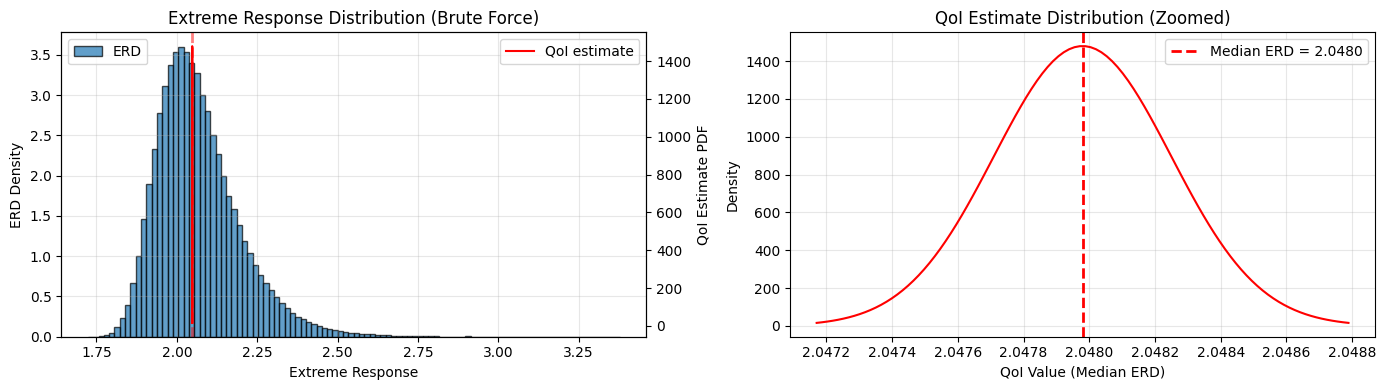

In [ ]:
# Define the period length (number of environment samples per period)
N_ENV_SAMPLES_PER_PERIOD = 1000

# Load pre-calculated brute force results (300,000 ERD samples)
precalced_erd_samples, precalced_erd_x = collect_or_calculate_results(N_ENV_SAMPLES_PER_PERIOD, 300_000)
brute_force_qoi_estimate = np.median(precalced_erd_samples)

# Calculate QoI uncertainty using population estimators
population_median_est_dist = population_estimators.sample_median_se(torch.tensor(precalced_erd_samples))

print(f"Brute force QoI (median ERD): {brute_force_qoi_estimate:.4f}")
print(f"This required 300,000 × {N_ENV_SAMPLES_PER_PERIOD} = 300M simulator calls!")

# Visualize the ERD with QoI uncertainty
fig, axes = plt.subplots(ncols=2, figsize=(14, 4))

# Left plot: ERD histogram with QoI uncertainty overlay
axes[0].hist(precalced_erd_samples, bins=100, density=True, alpha=0.7, edgecolor="black", label="ERD")
axes[0].set_xlabel("Extreme Response")
axes[0].set_ylabel("ERD Density")
axes[0].set_title("Extreme Response Distribution (Brute Force)")
axes[0].grid(alpha=0.3)

# Add QoI uncertainty on secondary y-axis
ax_twin = axes[0].twinx()
population_estimators.plot_dist(population_median_est_dist, ax=ax_twin, c="red", label="QoI estimate")
ax_twin.set_ylabel("QoI Estimate PDF")
ax_twin.legend(loc="upper right")

# Add median line
axes[0].axvline(brute_force_qoi_estimate, color="red", linestyle="--", linewidth=2, alpha=0.5)
axes[0].legend(loc="upper left")

# Right plot: Zoomed-in view of QoI uncertainty only
population_estimators.plot_dist(population_median_est_dist, ax=axes[1], c="red")
axes[1].axvline(
    brute_force_qoi_estimate,
    color="red",
    linestyle="--",
    linewidth=2,
    label=f"Median ERD = {brute_force_qoi_estimate:.4f}",
)
axes[1].set_xlabel("QoI Value (Median ERD)")
axes[1].set_ylabel("Density")
axes[1].set_title("QoI Estimate Distribution (Zoomed)")
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## Step 3: Build a Surrogate Model with Ax + BoTorch

Running the simulator many times is expensive.  
Instead, we build a **statistical surrogate** (a Gaussian Process) that learns:

- The mapping from inputs $(x1, x2)$ to the **location** parameter of the Gumbel noise
- The mapping from inputs $(x1, x2)$ to the **scale** parameter of the Gumbel noise

### 3.1 Configuration

Before creating the Ax experiment, we set up the core components:

1. **Search space**: Define the valid input domain — here, `x1` and `x2` both in $[0, 1]$
2. **Noise distribution**: Specify the distribution family for the simulator noise (Gumbel)
3. **Simulations per point**: How many simulator runs to perform at each training point to estimate the distribution parameters (`loc` and `scale`)

These configuration choices affect:

- How much information each training point provides (more simulations → better estimates)
- The computational cost per training point
- The smoothness of the resulting surrogate model

In [ ]:
# 1. Define the search space (2D: x1 and x2 both in [0, 1])
search_space = SearchSpace(
    parameters=[
        RangeParameter(name="x1", parameter_type=ParameterType.FLOAT, lower=0, upper=1),
        RangeParameter(name="x2", parameter_type=ParameterType.FLOAT, lower=0, upper=1),
    ]
)

# 2. Choose distribution for noise model
dist = gumbel_r

# 3. Number of simulations per point
N_SIMULATIONS_PER_POINT = 200

print("✓ Search space: 2D unit square")
print("✓ Distribution: Gumbel")
print(f"✓ Simulations per point: {N_SIMULATIONS_PER_POINT}")

✓ Search space: 2D unit square
✓ Distribution: Gumbel
✓ Simulations per point: 200


### 3.2 Initial training data (Sobol design)

We start by generating an initial, **space-filling** design using a Sobol sequence:

- Sobol points cover the space well without any modelling assumptions.
- At each Sobol point `x`, we run the simulator multiple times to estimate:
  - the mean (location) and
  - variability (scale) of the response distribution.

These initial points are used to fit the first GP surrogate using `Models.BOTORCH_MODULAR`.

**What the GP actually learns:**

The `make_experiment()` function wraps the simulator with logic that:

1. Runs the simulator `N_SIMULATIONS_PER_POINT` times at each training point `x`
2. Fits the Gumbel distribution to those samples to estimate `loc(x)` and `scale(x)`
3. Provides these fitted parameters to the GP

So the GP learns **two separate mappings**:
- `x → loc`: How the location parameter varies across the input space
- `x → scale`: How the scale parameter varies across the input space

The GP is **not** trained on raw `(x, y)` pairs. Instead, it learns the underlying distribution parameters from multiple noisy observations at each `x`.

In [6]:
# Helper function to create experiments with consistent settings
def make_exp():
    return make_experiment(sim, search_space, dist, n_simulations_per_point=N_SIMULATIONS_PER_POINT)


# Create experiment and add 30 initial training points
exp = make_exp()
add_sobol_points_to_experiment(exp, n_iter=30, seed=8)

# Train the surrogate model
botorch_model_bridge = Models.BOTORCH_MODULAR(
    experiment=exp,
    data=exp.fetch_data(),
)

print(f"✓ Trained GP with {len(exp.trials)} training points")
print(f"✓ Total simulator calls: {len(exp.trials) * N_SIMULATIONS_PER_POINT}")

✓ Trained GP with 30 training points
✓ Total simulator calls: 6000


### 3.3 Comparing surrogate vs simulator

To build intuition, we pick a single test point `x = [0.5, 0.5]` and:

- Sample many responses from the **true simulator**
- Predict the mean Gumbel distribution parameters from the **surrogate** 
- Sample from the GP posterior to visualize uncertainty

The plot shows:

- **Histogram**: 200 simulator runs at the test point, showing the true response distribution
- **Red line**: The surrogate's mean predicted Gumbel distribution 
- **Grey lines**: 10 sampled Gumbel distributions from the GP posterior

The GP posterior captures uncertainty about the true `loc` and `scale` parameters at this location. The grey lines show the range of plausible response distributions consistent with the training data. When the surrogate has high confidence, these lines cluster tightly around the mean; when uncertain, they spread out.

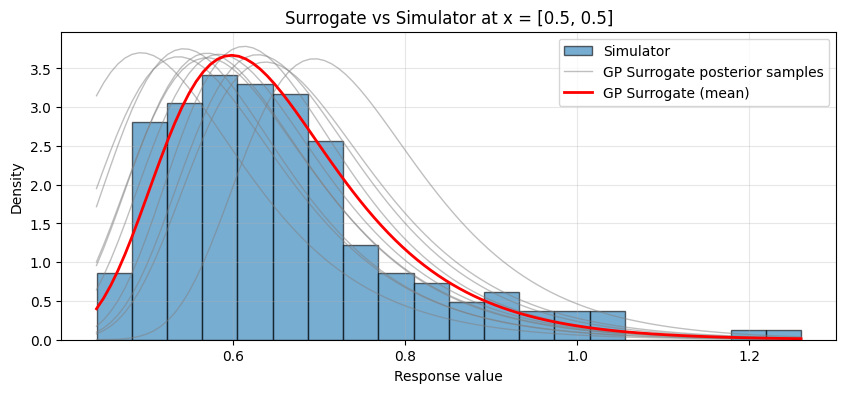

Surrogate prediction: loc=0.598, scale=0.100


In [ ]:
# Predict at x = [0.5, 0.5]
test_x = {"x1": 0.5, "x2": 0.5}
pred_mean, pred_covariance = botorch_model_bridge.predict([ObservationFeatures(parameters=test_x)])

# Get simulator samples at the same point
simulator_samples = sim(np.array([[0.5, 0.5]]), n_simulations_per_point=200).flatten()

# Mean prediction
pred_dist_mean = dist(loc=pred_mean["loc"], scale=pred_mean["scale"])
x_points = np.linspace(simulator_samples.min(), simulator_samples.max(), 100)

# Sample from GP posterior to show uncertainty
mean = np.array([pred_mean["loc"], pred_mean["scale"]]).flatten()
covariance = np.array(
    [
        [pred_covariance["loc"]["loc"], pred_covariance["loc"]["scale"]],
        [pred_covariance["scale"]["loc"], pred_covariance["scale"]["scale"]],
    ]
).reshape(2, 2)

surrogate_distribution = scipy.stats.multivariate_normal(mean, covariance)
posterior_samples = surrogate_distribution.rvs(size=10, random_state=42)

# Plot
plt.figure(figsize=(10, 4))
plt.hist(simulator_samples, bins=20, density=True, alpha=0.6, label="Simulator", edgecolor="black")

# Plot posterior samples with transparency
for i, sample in enumerate(posterior_samples):
    sample_dist = dist(loc=sample[0], scale=sample[1])
    if i == 0:
        plt.plot(
            x_points, sample_dist.pdf(x_points), "grey", linewidth=1, alpha=0.5, label="GP Surrogate posterior samples"
        )
    else:
        plt.plot(x_points, sample_dist.pdf(x_points), "grey", linewidth=1, alpha=0.5)

# Plot mean prediction on top
plt.plot(x_points, pred_dist_mean.pdf(x_points), "r-", linewidth=2, label="GP Surrogate (mean)")

plt.xlabel("Response value")
plt.ylabel("Density")
plt.title("Surrogate vs Simulator at x = [0.5, 0.5]")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

print(f"Surrogate prediction: loc={pred_mean['loc'][0]:.3f}, scale={pred_mean['scale'][0]:.3f}")

## Step 4: Estimate the QoI from the Surrogate

Now that we have a surrogate model, we can use it to estimate our **Quantity of Interest** (the median of the ERD) **without repeatedly calling the expensive simulator**.

The key idea:

- The surrogate is fast to evaluate.
- We use it to *emulate* what the simulator would do over many periods of environment samples.
- We propagate both:
  - **environment randomness**, and
  - **surrogate uncertainty**
  into our QoI estimate.

### 4.1 Environment sampling via DataLoader

We wrap our environment samples in a small `Dataset` and `DataLoader`:

- This lets the QoI estimator iterate over batches of environment points.
- We can easily control how many total environment samples we use for the QoI calculation.
- Different runs (with different seeds) can use different resampled subsets if desired.



In [8]:
# Set up environment data loader
n_env_samples = 4_000
dataset = MinimalDataset(env_data)
sampler = FixedRandomSampler(dataset, num_samples=n_env_samples, seed=10, replacement=True)
dataloader = DataLoader(dataset, sampler=sampler, batch_size=256)

### 4.2 QoI estimator: MarginalCDFExtrapolation

We use Axtreme’s `MarginalCDFExtrapolation` as a ready-made QoI estimator that:

1. Draws batches of environment inputs from the loader
2. Uses the surrogate model to obtain a distribution of responses at each input
3. Forms many **periods** of length `N_ENV_SAMPLES_PER_PERIOD`
4. Extracts the **maximum** response in each period
5. Estimates the **median** of the resulting extreme response distribution
6. Repeats under different draws from the GP posterior to capture model uncertainty

The result is a **distribution over the QoI**, not just a single number.



In [9]:
# Create QoI estimator
qoi_estimator = MarginalCDFExtrapolation(
    env_iterable=dataloader,
    period_len=N_ENV_SAMPLES_PER_PERIOD,
    quantile=torch.tensor(0.5),  # Median
    quantile_accuracy=torch.tensor(0.01),
    posterior_sampler=UTSampler(),
)

print("✓ QoI estimator configured")

✓ QoI estimator configured


### 4.3 Effect of training data size

To see the impact of more simulator data, we repeat:

- Use `N` training points to fit a surrogate
- Use that surrogate to estimate the QoI distribution

for several values of `N` (e.g. 30, 50, 128).

For each `N` we:

- Approximate the QoI distribution with a Normal using the sampler’s `mean` and `var` methods
- Plot the corresponding PDF
- Overlay the **brute-force QoI** as a vertical line

Results:

- With **few** training points, the QoI distribution is **wide** (high uncertainty).
- As we add more training points, the distribution becomes **sharper** (narrower), and its mean stays close to the brute-force value.

This confirms that:

> The surrogate-based QoI estimator converges towards the brute-force answer as more simulator data is added.


In [ ]:
# Train surrogates with different numbers of training points
n_training_points = [30, 64, 128]
results = []

for n_points in n_training_points:
    # Create and train experiment
    exp_temp = make_exp()
    add_sobol_points_to_experiment(exp_temp, n_iter=n_points, seed=8)

    model_bridge = Models.BOTORCH_MODULAR(experiment=exp_temp, data=exp_temp.fetch_data())

    # Set up transforms
    input_transform, outcome_transform = transforms.ax_to_botorch_transform_input_output(
        transforms=list(model_bridge.transforms.values()), outcome_names=model_bridge.outcomes
    )
    qoi_estimator.input_transform = input_transform
    qoi_estimator.outcome_transform = outcome_transform

    # Estimate QoI
    model = model_bridge.model.surrogate.model
    result = qoi_estimator(model)
    results.append(result)

    print(f"✓ Computed QoI with {n_points} training points")

✓ Computed QoI with 30 training points
✓ Computed QoI with 64 training points
✓ Computed QoI with 128 training points


Let's see how the QoI estimate improves with more training data:

C:\Users\sarelm\AppData\Local\Temp\ipykernel_21132\844206477.py:6: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

C:\Users\sarelm\AppData\Local\Temp\ipykernel_21132\844206477.py:7: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



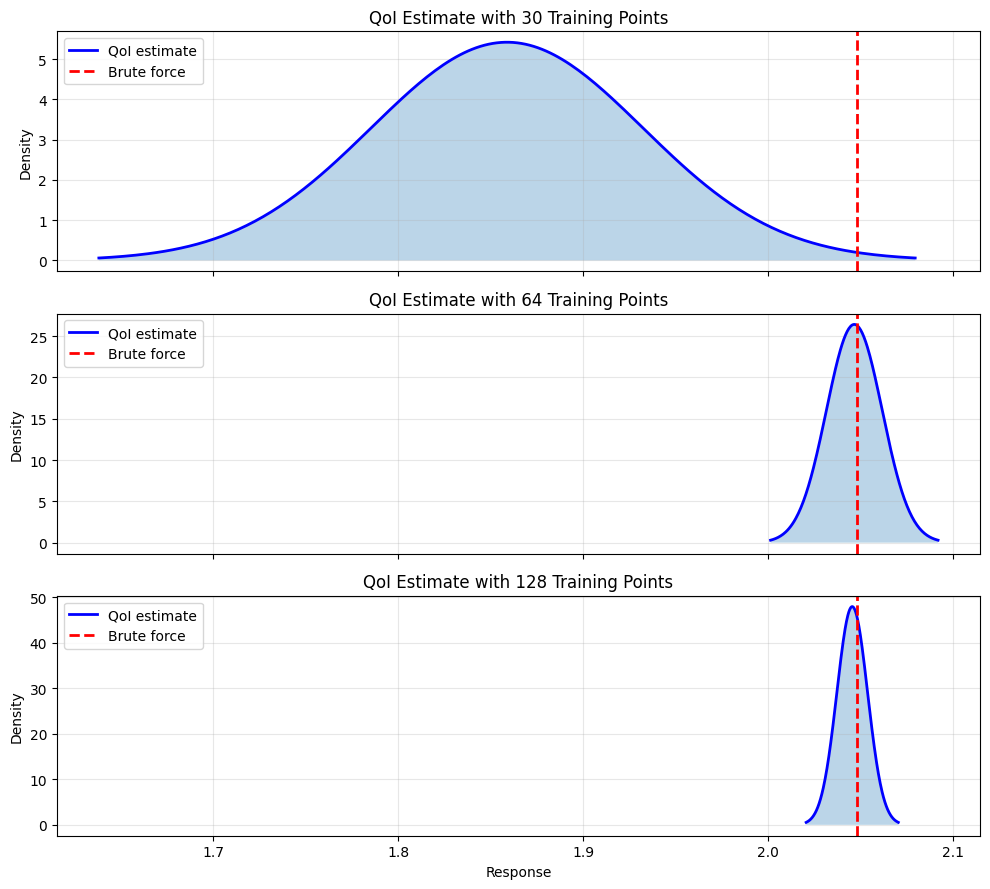

In [ ]:
# Visualize QoI estimates
fig, axes = plt.subplots(nrows=len(n_training_points), figsize=(10, 3 * len(n_training_points)), sharex=True)

for ax, estimate, n_points in zip(axes, results, n_training_points, strict=True):
    # Extract mean and variance from the estimate
    mean = qoi_estimator.posterior_sampler.mean(torch.tensor(estimate), -1)
    var = qoi_estimator.posterior_sampler.var(torch.tensor(estimate), -1)
    qoi_dist = Normal(mean, var**0.5)

    # Plot QoI distribution
    x_range = torch.linspace(float(mean - 3 * var**0.5), float(mean + 3 * var**0.5), 200)
    ax.plot(x_range.numpy(), torch.exp(qoi_dist.log_prob(x_range)).numpy(), "b-", linewidth=2, label="QoI estimate")
    ax.fill_between(x_range.numpy(), 0, torch.exp(qoi_dist.log_prob(x_range)).numpy(), alpha=0.3)

    # Add brute force reference
    ax.axvline(brute_force_qoi_estimate, color="red", linestyle="--", linewidth=2, label="Brute force")

    ax.set_title(f"QoI Estimate with {n_points} Training Points")
    ax.set_ylabel("Density")
    ax.legend()
    ax.grid(alpha=0.3)

axes[-1].set_xlabel("Response")
plt.tight_layout()
plt.show()

## 5. Design of Experiments (DoE)

In the earlier sections, we saw that adding more simulator training data improves our surrogate model and reduces the uncertainty of our **Quantity of Interest (QoI)** estimate. However, **where** we choose to evaluate the simulator matters just as much as **how many** points we evaluate.

Design of Experiments (DoE) helps us choose simulator inputs intelligently, so that each new simulation gives us the **maximum possible reduction in QoI uncertainty**.

In this section we compare:

- a baseline approach (random Sobol sampling), and
- a QoI-aware approach that uses Axtreme’s `QoILookAhead` acquisition function to pick the most informative points.

We will track the QoI after each iteration to see which strategy converges faster.

### 5.1 QoI tracking metric and stopping criteria

To monitor the progress of the DoE, we attach a special metric — `QoIMetric` — to the Ax experiment. After each iteration:

- The surrogate model is updated.
- The QoI is re-estimated using the updated surrogate.
- The QoI estimate (mean and standard error) is stored inside the experiment's data.

This allows us to plot the QoI over time and optionally stop early when the QoI uncertainty becomes sufficiently small.

We implement:

1. **QoI tracking metric**: Automatically computes and logs the QoI after each surrogate update
2. **Stopping criterion** (`sem_stopping_criteria`): Checks if the standard error of the QoI drops below a threshold (e.g., 0.02)
3. **Trial runner** (`run_trials`): A helper function that:
   - Runs warm-up trials using a space-filling design (e.g., Sobol)
   - Then runs DoE trials using a specified acquisition strategy
   - Checks the stopping criterion after each DoE iteration
   - Returns early if the QoI uncertainty is sufficiently small

This approach avoids unnecessary simulator calls once the QoI estimate is sufficiently accurate.

In [ ]:
# Define QoI tracking metric
QOI_METRIC = QoIMetric(
    name="QoIMetric",
    qoi_estimator=qoi_estimator,
    minimum_data_points=3,  # don't compute QoI until some data exists
    attach_transforms=True,
)


# Define stopping criteria based on standard error of the mean (SEM)
def sem_stopping_criteria(experiment: Experiment, sem_threshold: float = 0.02, metric_name: str = "QoIMetric") -> bool:
    """Stop when the standard error of the QoI estimate drops below a threshold."""
    metrics = experiment.fetch_data()
    df = metrics.df
    qoi_rows = df[df["metric_name"] == metric_name]

    if len(qoi_rows) == 0:
        # No QoI yet
        return False

    latest = qoi_rows.iloc[-1]
    sem = latest["sem"]

    # Stop if SEM is finite and sufficiently small
    return (sem is not None) and (not np.isnan(sem)) and (sem <= sem_threshold)


# Define function to run trials with progress output
def run_trials(
    experiment: Experiment,
    warm_up_generator: Callable[[Experiment], GeneratorRun],
    doe_generator: Callable[[Experiment], GeneratorRun],
    warm_up_runs: int = 3,
    doe_runs: int = 15,
    stopping_criteria: Callable[[Experiment], bool] | None = None,
) -> int:
    """Run warm-up + DoE trials with simple progress output."""

    total_iters = warm_up_runs + doe_runs
    print(f"Starting DoE run: {warm_up_runs} warm-up + {doe_runs} DoE iterations")
    print("-" * 60)

    for i in range(total_iters):
        phase = "Warm-up" if i < warm_up_runs else "DoE"

        # Select generator
        gen_fn = warm_up_generator if i < warm_up_runs else doe_generator
        gen = gen_fn(experiment)

        # Run trial
        trial = experiment.new_trial(gen)
        trial.run()
        trial.mark_completed()

        # Print progress
        print(f"[{i + 1}/{total_iters}] {phase} iteration {i + 1} completed")

        # Stopping criteria only valid during DoE
        if (i >= warm_up_runs) and (stopping_criteria is not None) and stopping_criteria(experiment):
            print(f"✓ Stopping criterion met after {i - warm_up_runs + 1} DoE iterations.")
            print("-" * 60)
            return i + 1

    print("✓ DoE run completed.")
    print("-" * 60)
    return total_iters

### 5.2 Baseline: Sobol-only DoE

As a baseline, we perform DoE using only Sobol points:

- Sobol sequences are space-filling and require no modelling assumptions.
- They cover the full input domain evenly.
- They do not focus sampling effort on regions that matter most for the QoI.

The Sobol-only experiment therefore provides a fair reference point to compare against more advanced acquisition strategies.

We:

1. Create a new Ax experiment with the same simulator, search space, and noise model as before.
2. Attach the QoI tracking metric.
3. Run:
   - a few warm-up Sobol points, followed by
   - many DoE Sobol points.
4. Record the number of iterations performed (possibly fewer if the stopping criterion triggers early).

This gives us a curve describing how the QoI estimate improves when sampling is uniform and naïve.

In [13]:
# Baseline: Sobol-only DoE
exp_sobol = make_exp()
exp_sobol.add_tracking_metric(QOI_METRIC)

# Sobol generator (kept outside the loop so its internal state persists)
sobol = Models.SOBOL(search_space=exp_sobol.search_space, seed=5)


# Sobol generator function
def sobol_generator_run(_: Experiment) -> GeneratorRun:
    return sobol.gen(1)


print("Running Sobol-only experiment...")
n_sobol_iters = run_trials(
    experiment=exp_sobol,
    warm_up_generator=sobol_generator_run,
    doe_generator=sobol_generator_run,
    warm_up_runs=3,
    doe_runs=100,
    stopping_criteria=sem_stopping_criteria,
)

Running Sobol-only experiment...
Starting DoE run: 3 warm-up + 100 DoE iterations
------------------------------------------------------------
[1/103] Warm-up iteration 1 completed
[2/103] Warm-up iteration 2 completed
[3/103] Warm-up iteration 3 completed
[4/103] DoE iteration 4 completed
[5/103] DoE iteration 5 completed
[6/103] DoE iteration 6 completed
[7/103] DoE iteration 7 completed
[8/103] DoE iteration 8 completed
[9/103] DoE iteration 9 completed
[10/103] DoE iteration 10 completed
[11/103] DoE iteration 11 completed
[12/103] DoE iteration 12 completed
[13/103] DoE iteration 13 completed
[14/103] DoE iteration 14 completed
[15/103] DoE iteration 15 completed
[16/103] DoE iteration 16 completed
[17/103] DoE iteration 17 completed
[18/103] DoE iteration 18 completed
[19/103] DoE iteration 19 completed
[20/103] DoE iteration 20 completed
[21/103] DoE iteration 21 completed
[22/103] DoE iteration 22 completed
[23/103] DoE iteration 23 completed
[24/103] DoE iteration 24 completed

### 5.3 QoI-aware DoE with `QoILookAhead`

Randomly exploring the search space is wasteful when our goal is to reduce QoI uncertainty, not to approximate the simulator everywhere equally.

To address this, Axtreme provides a custom acquisition function, `QoILookAhead`.

This acquisition function:

- Uses the current GP surrogate.
- Anticipates how much one more simulator evaluation will reduce the QoI uncertainty.
- Selects the input location where this reduction is expected to be largest.

Conceptually, it prioritizes simulator points that are most influential in shaping the extreme response distribution.

This is significantly more efficient than Sobol sampling, especially when the QoI depends heavily on only a subset of the input space.

To run QoI-aware DoE:

1. For each DoE iteration, we build a BoTorch model bridge equipped with the `QoILookAhead` acquisition.
2. We use Ax’s built-in acquisition optimizer (for example, Nelder–Mead for robustness in non-smooth cases).
3. The best acquisition point becomes the next simulator evaluation.
4. After each point, the QoI is re-estimated and logged by the tracking metric.

This creates a feedback loop where the model learns faster in QoI-critical regions.

In [14]:
# QoI-aware DoE with QoILookAhead acquisition

# Choose the acquisition function
acquisition_function_class = QoILookAhead


# Define QoILookAhead DoE generator function
def look_ahead_generator_run(experiment: Experiment) -> GeneratorRun:
    """Generate a new point by optimising the QoILookAhead acquisition."""

    # First: build a model bridge to recover the Ax→BoTorch transforms
    model_bridge_for_transforms = Models.BOTORCH_MODULAR(
        experiment=experiment,
        data=experiment.fetch_data(metrics=list(experiment.optimization_config.metrics.values())),
        fit_tracking_metrics=False,
    )

    input_transform, outcome_transform = transforms.ax_to_botorch_transform_input_output(
        transforms=list(model_bridge_for_transforms.transforms.values()),
        outcome_names=model_bridge_for_transforms.outcomes,
    )

    # Feed the transforms into the QoI estimator so it interprets inputs/outputs correctly
    qoi_estimator.input_transform = input_transform
    qoi_estimator.outcome_transform = outcome_transform

    # Build a model bridge with a custom acquisition function
    model_bridge_with_acq = Models.BOTORCH_MODULAR(
        experiment=experiment,
        data=experiment.fetch_data(),
        botorch_acqf_class=acquisition_function_class,
        fit_tracking_metrics=False,
        acquisition_options={
            "qoi_estimator": qoi_estimator,
            "sampler": sampling.MeanSampler(),
        },
    )

    # Optimise the acquisition to find the next candidate
    return model_bridge_with_acq.gen(
        1,
        model_gen_options={
            "optimizer_kwargs": {
                "num_restarts": 20,
                "raw_samples": 50,
                "options": {
                    "with_grad": False,  # QoILookAhead may not be smooth
                    "method": "Nelder-Mead",
                    "maxfev": 5,
                },
                "retry_on_optimization_warning": False,
            }
        },
    )


# Run the QoI-aware DoE
exp_look_ahead = make_exp()
exp_look_ahead.add_tracking_metric(QOI_METRIC)

# Sobol generator for warm-up (kept outside the loop so its internal state persists)
sobol_for_warmup = Models.SOBOL(search_space=exp_look_ahead.search_space, seed=5)


# Sobol generator function for warm-up
def sobol_warmup_run(_: Experiment) -> GeneratorRun:
    return sobol_for_warmup.gen(1)


print("Running QoI-aware look-ahead experiment...")
n_lookahead_iters = run_trials(
    experiment=exp_look_ahead,
    warm_up_generator=sobol_warmup_run,
    doe_generator=look_ahead_generator_run,
    warm_up_runs=3,
    doe_runs=40,
    stopping_criteria=sem_stopping_criteria,
)

Running QoI-aware look-ahead experiment...
Starting DoE run: 3 warm-up + 40 DoE iterations
------------------------------------------------------------
[1/43] Warm-up iteration 1 completed
[2/43] Warm-up iteration 2 completed
[3/43] Warm-up iteration 3 completed
[4/43] DoE iteration 4 completed
[5/43] DoE iteration 5 completed
[6/43] DoE iteration 6 completed
[7/43] DoE iteration 7 completed
[8/43] DoE iteration 8 completed
[9/43] DoE iteration 9 completed
[10/43] DoE iteration 10 completed
[11/43] DoE iteration 11 completed
[12/43] DoE iteration 12 completed
[13/43] DoE iteration 13 completed
[14/43] DoE iteration 14 completed
[15/43] DoE iteration 15 completed
[16/43] DoE iteration 16 completed
[17/43] DoE iteration 17 completed
[18/43] DoE iteration 18 completed
[19/43] DoE iteration 19 completed
[20/43] DoE iteration 20 completed
[21/43] DoE iteration 21 completed
[22/43] DoE iteration 22 completed
✓ Stopping criterion met after 19 DoE iterations.
----------------------------------

### 5.4 Comparing Sobol and QoI-aware DoE

Finally, we compare results from both strategies.

Using Axtreme’s `plot_qoi_estimates_from_experiment`, we visualize:

- The QoI estimate at each iteration.
- The uncertainty bands (SEM).
- The brute-force QoI as a reference line.
- Curves for both:
  - Sobol-only DoE, and
  - QoILookAhead-based DoE.

This makes it easy to see:

- How quickly each method reduces QoI uncertainty.
- Whether either method shows bias.
- How many simulator evaluations are required to reach a target confidence level.

In typical problems, we expect:

- Sobol: uncertainty decreases steadily but relatively slowly.
- QoILookAhead: uncertainty drops much faster because it samples only where the QoI is sensitive.

In real applications, this difference can translate to far fewer simulator evaluations for similar or better QoI accuracy.

This completes the end-to-end Axtreme workflow: from defining a simulation problem, through surrogate modeling and QoI estimation, to intelligent experiment design.

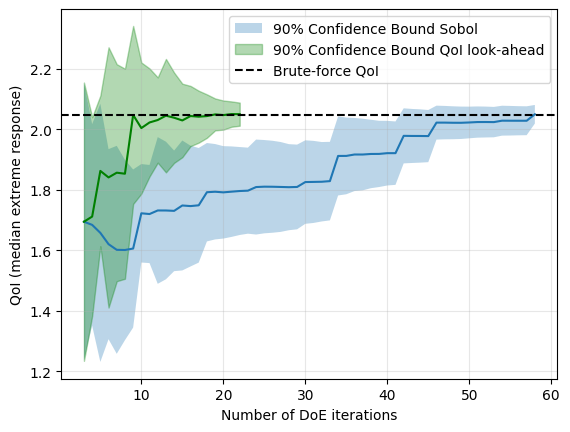

In [ ]:
# 5.4 Compare QoI evolution

ax = plot_qoi_estimates_from_experiment(exp_sobol, name="Sobol")
ax = plot_qoi_estimates_from_experiment(
    exp_look_ahead,
    ax=ax,
    color="green",
    name="QoI look-ahead",
)

ax.axhline(float(brute_force_qoi_estimate), color="black", linestyle="--", label="Brute-force QoI")

ax.set_xlabel("Number of DoE iterations")
ax.set_ylabel("QoI (median extreme response)")
ax.legend()
ax.grid(alpha=0.3)

plt.show()

### 5.5 Spatial Distribution of Selected Points

To understand **where** each DoE strategy chooses to evaluate the simulator, we visualize the selected points in the 2D input space overlaid on:

1. **Environment density**: Shows the distribution of environment samples (grey histogram)
2. **Extreme response density**: Shows where extreme responses originated during brute-force simulation (red histogram)
3. **Combined view**: Both densities overlaid to reveal the relationship

Key insights:

- **Sobol points (blue circles)**: Distributed uniformly across the entire input space, regardless of where extremes occur
- **QoI-aware points (red triangles)**: Concentrated in regions that contribute most to extreme responses

The point labels indicate the order in which they were selected during DoE.

This visualization reveals why QoI-aware DoE is more efficient: it focuses simulator evaluations on the critical regions of the input space where the QoI is most sensitive.

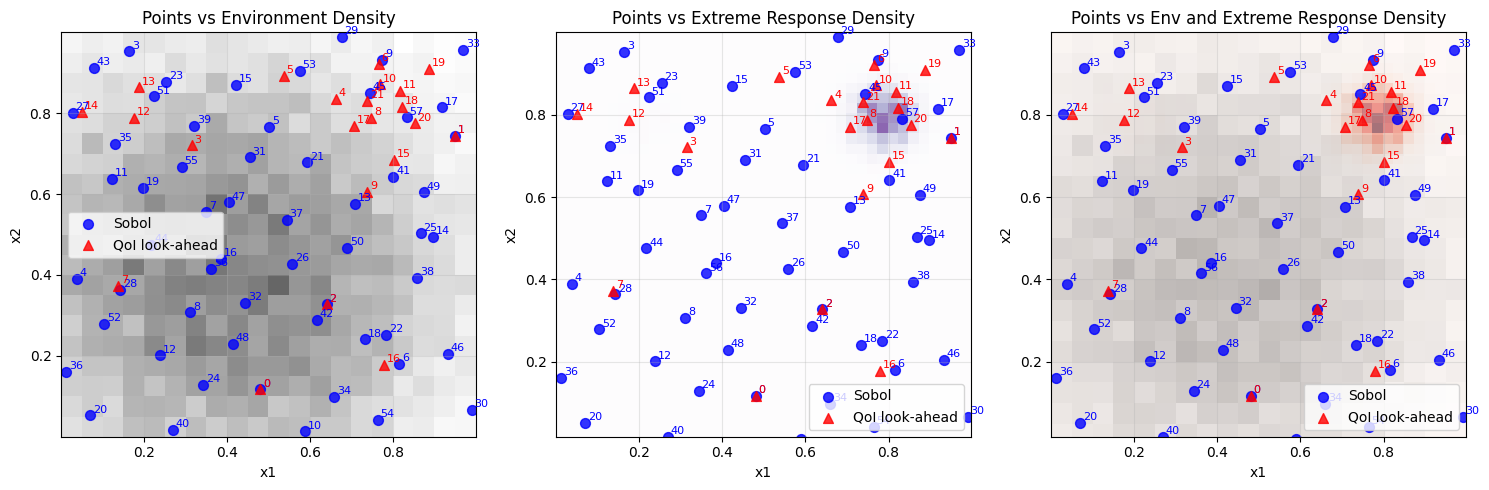

In [16]:
def plot_2dtrials(
    exp: Experiment, ax: plt.Axes | None = None, colour: str = "blue", marker: str = "o", label: str | None = None
) -> plt.Axes:
    """Plot the points and number the datapoints added over DoE."""
    if ax is None:
        _, ax = plt.subplots(figsize=(8, 6))

    trials = []
    trial_indices = []

    for trial_idx, trial in exp.trials.items():
        if trial.arm:
            params = trial.arm.parameters.values()
            trials.append(list(params))
            trial_indices.append(trial_idx)

    points = np.array(trials)
    ax.scatter(points[:, 0], points[:, 1], alpha=0.8, s=50, label=label, c=colour, marker=marker)

    for i, (x, y) in enumerate(points):
        ax.annotate(str(trial_indices[i]), (x, y), xytext=(2, 2), textcoords="offset points", fontsize=8, color=colour)

    return ax


# Create three-panel visualization
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Panel 1: Points vs Environment Density
axes[0].set_title("Points vs Environment Density")
axes[0].hist2d(env_data[:, 0], env_data[:, 1], bins=20, alpha=0.6, cmap="Greys", zorder=-1)

# Panel 2: Points vs Extreme Response Density
axes[1].set_title("Points vs Extreme Response Density")
axes[1].hist2d(precalced_erd_x[:, 0], precalced_erd_x[:, 1], bins=40, alpha=0.6, cmap="Purples", zorder=-1)

# Panel 3: Points vs Combined Density
axes[2].set_title("Points vs Env and Extreme Response Density")
axes[2].hist2d(env_data[:, 0], env_data[:, 1], bins=20, alpha=0.6, cmap="Greys", zorder=-1)
axes[2].hist2d(precalced_erd_x[:, 0], precalced_erd_x[:, 1], bins=40, alpha=0.5, cmap="Reds", zorder=-1)

# Add DoE points to all panels
for ax in axes:
    ax.set_xlabel("x1")
    ax.set_ylabel("x2")
    plot_2dtrials(exp_sobol, colour="blue", ax=ax, label="Sobol")
    plot_2dtrials(exp_look_ahead, colour="red", ax=ax, label="QoI look-ahead", marker="^")
    ax.legend()
    ax.grid(visible=True, alpha=0.3)

plt.tight_layout()
plt.show()